In [80]:
import pandas as pd

ratings_df = pd.read_csv('/ratings.csv')
movies_df = pd.read_csv('/movies.csv')
tags_df = pd.read_csv('/tags.csv')
links_df = pd.read_csv('/links.csv')

print('Ratings DataFrame head:')
print(ratings_df.head())
print('\nMovies DataFrame head:')
print(movies_df.head())
print('\nTags DataFrame head:')
print(tags_df.head())
print('\nLinks DataFrame head:')
print(links_df.head())

Ratings DataFrame head:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies DataFrame head:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Tags DataFrame head:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2  

In [81]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df = ratings_df.sort_values(by=['userId', 'timestamp'])

print('Ratings DataFrame after timestamp conversion and sorting:')
print(ratings_df.head())

Ratings DataFrame after timestamp conversion and sorting:
     userId  movieId  rating           timestamp
43        1      804     4.0 2000-07-30 18:08:19
73        1     1210     5.0 2000-07-30 18:08:19
120       1     2018     5.0 2000-07-30 18:08:43
171       1     2628     4.0 2000-07-30 18:08:43
183       1     2826     4.0 2000-07-30 18:08:43


In [82]:
N = 1

train_data = []
test_data = []

for userId, group in ratings_df.groupby('userId'):
    if len(group) > N:
        train_data.append(group.iloc[:-N])
        test_data.append(group.iloc[-N:])
    else:
        train_data.append(group)

train_ratings = pd.concat(train_data)
test_ratings = pd.concat(test_data) if test_data else pd.DataFrame(columns=ratings_df.columns)

print('Train Ratings DataFrame head:')
print(train_ratings.head())
print('\nTest Ratings DataFrame head:')
print(test_ratings.head())
print(f'\nShape of train_ratings: {train_ratings.shape}')
print(f'Shape of test_ratings: {test_ratings.shape}')

Train Ratings DataFrame head:
     userId  movieId  rating           timestamp
43        1      804     4.0 2000-07-30 18:08:19
73        1     1210     5.0 2000-07-30 18:08:19
120       1     2018     5.0 2000-07-30 18:08:43
171       1     2628     4.0 2000-07-30 18:08:43
183       1     2826     4.0 2000-07-30 18:08:43

Test Ratings DataFrame head:
     userId  movieId  rating           timestamp
161       1     2492     4.0 2000-08-08 07:27:42
247       2    80489     4.5 2015-10-24 19:35:40
281       3     2424     0.5 2011-05-27 02:44:53
502       4     4246     4.0 2001-12-05 17:49:02
545       5      474     4.0 1996-11-08 06:42:17

Shape of train_ratings: (100226, 4)
Shape of test_ratings: (610, 4)


In [83]:
import numpy as np

movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', '')
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|') if x else [])

tags_df['tag'] = tags_df['tag'].fillna('')
tags_df['tag'] = tags_df['tag'].str.lower()
tags_df['tag'] = tags_df['tag'].str.strip()

print('Movies DataFrame after cleaning:')
print(movies_df.head())
print('\nTags DataFrame after cleaning:')
print(tags_df.head())

Movies DataFrame after cleaning:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]  

Tags DataFrame after cleaning:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     boxing story  1445715207
4       2    89774              mma  1445715200


In [84]:
user_item_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

print('User-Item Interaction Matrix head:')
print(user_item_matrix.head())
print(f'\nShape of User-Item Interaction Matrix: {user_item_matrix.shape}')

User-Item Interaction Matrix head:
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0   

In [85]:
import numpy as np

all_genres = movies_df['genres'].explode().unique()
all_genres = [g for g in all_genres if g]

genre_features_df = movies_df.copy()
for genre in all_genres:
    genre_features_df[genre] = genre_features_df['genres'].apply(lambda x: 1 if genre in x else 0)

genre_features_df = genre_features_df.drop(columns=['title', 'genres'])

print('Unique Genres extracted:')
print(all_genres[:10])
print(f'Number of unique genres: {len(all_genres)}')
print('\nGenre Features DataFrame head:')
print(genre_features_df.head())
print(f'Shape of Genre Features DataFrame: {genre_features_df.shape}')

Unique Genres extracted:
['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller']
Number of unique genres: 20

Genre Features DataFrame head:
   movieId  Adventure  Animation  Children  Comedy  Fantasy  Romance  Drama  \
0        1          1          1         1       1        1        0      0   
1        2          1          0         1       0        1        0      0   
2        3          0          0         0       1        0        1      0   
3        4          0          0         0       1        0        1      1   
4        5          0          0         0       1        0        0      0   

   Action  Crime  ...  Horror  Mystery  Sci-Fi  War  Musical  Documentary  \
0       0      0  ...       0        0       0    0        0            0   
1       0      0  ...       0        0       0    0        0            0   
2       0      0  ...       0        0       0    0        0            0   
3       0      0  ...

In [87]:
import numpy as np

movie_tags_df = tags_df.groupby('movieId')['tag'].apply(lambda x: list(set([t for t in x if t]))).reset_index()
movie_tags_df.rename(columns={'tag': 'tags'}, inplace=True)

all_tags = movie_tags_df['tags'].explode().unique()
all_tags = [t for t in all_tags if t]

tag_features_df = movies_df[['movieId']].copy()
tag_features_df = tag_features_df.merge(movie_tags_df, on='movieId', how='left').fillna('')

tag_features_df['tags'] = tag_features_df['tags'].apply(lambda x: x if isinstance(x, list) else [])

for tag in all_tags:
    if tag:
        tag_features_df[tag] = tag_features_df['tags'].apply(lambda x: 1 if tag in x else 0)

tag_features_df = tag_features_df.drop(columns=['tags'])

print('Movie Tags DataFrame head:')
print(movie_tags_df.head())
print(f'Number of unique tags: {len(all_tags)}')
print('Tag Features DataFrame head:')
print(tag_features_df.head())
print(f'Shape of Tag Features DataFrame: {tag_features_df.shape}')

/tmp/ipython-input-1012973153.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features_df[tag] = tag_features_df['tags'].apply(lambda x: 1 if tag in x else 0)
/tmp/ipython-input-1012973153.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features_df[tag] = tag_features_df['tags'].apply(lambda x: 1 if tag in x else 0)
/tmp/ipython-input-1012973153.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

Movie Tags DataFrame head:
   movieId                                               tags
0        1                                       [fun, pixar]
1        2  [robin williams, game, magic board game, fantasy]
2        3                                       [moldy, old]
3        5                                [remake, pregnancy]
4        7                                           [remake]
Number of unique tags: 1475
Tag Features DataFrame head:
   movieId  fun  pixar  robin williams  game  magic board game  fantasy  \
0        1    1      1               0     0                 0        0   
1        2    0      0               1     1                 1        1   
2        3    0      0               0     0                 0        0   
3        4    0      0               0     0                 0        0   
4        5    0      0               0     0                 0        0   

   moldy  old  remake  ...  allegorical  dwayne johnson  bad music  \
0      0    0       0  

/tmp/ipython-input-1012973153.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features_df[tag] = tag_features_df['tags'].apply(lambda x: 1 if tag in x else 0)
/tmp/ipython-input-1012973153.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features_df[tag] = tag_features_df['tags'].apply(lambda x: 1 if tag in x else 0)
/tmp/ipython-input-1012973153.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [88]:
import numpy as np

movie_tags_df = tags_df.groupby('movieId')['tag'].apply(lambda x: list(set([t for t in x if t]))).reset_index()
movie_tags_df.rename(columns={'tag': 'tags'}, inplace=True)

exploded_tags = movie_tags_df.explode('tags')

tag_dummies = pd.get_dummies(exploded_tags[['movieId', 'tags']], columns=['tags'], prefix='', prefix_sep='')

tag_features_df = tag_dummies.groupby('movieId').sum().reset_index()

tag_features_df = movies_df[['movieId']].merge(tag_features_df, on='movieId', how='left').fillna(0)

all_tags = movie_tags_df['tags'].explode().unique()
all_tags = [t for t in all_tags if t]

print('Movie Tags DataFrame head (after aggregation):')
print(movie_tags_df.head())
print(f'Number of unique tags: {len(all_tags)}')
print('\nTag Features DataFrame head (after one-hot encoding):')
print(tag_features_df.head())
print(f'Shape of Tag Features DataFrame: {tag_features_df.shape}')

Movie Tags DataFrame head (after aggregation):
   movieId                                               tags
0        1                                       [fun, pixar]
1        2  [robin williams, game, magic board game, fantasy]
2        3                                       [moldy, old]
3        5                                [remake, pregnancy]
4        7                                           [remake]
Number of unique tags: 1475

Tag Features DataFrame head (after one-hot encoding):
   movieId  "artsy"  06 oscar nominated best movie - animation  1900s  1920s  \
0        1      0.0                                        0.0    0.0    0.0   
1        2      0.0                                        0.0    0.0    0.0   
2        3      0.0                                        0.0    0.0    0.0   
3        4      0.0                                        0.0    0.0    0.0   
4        5      0.0                                        0.0    0.0    0.0   

   1950s  1960s  

In [89]:
movie_features_df = genre_features_df.merge(tag_features_df, on='movieId', how='left')

print('Movie Features DataFrame head:')
print(movie_features_df.head())
print(f'Shape of Movie Features DataFrame: {movie_features_df.shape}')

Movie Features DataFrame head:
   movieId  Adventure  Animation  Children  Comedy  Fantasy  Romance  Drama  \
0        1          1          1         1       1        1        0      0   
1        2          1          0         1       0        1        0      0   
2        3          0          0         0       1        0        1      0   
3        4          0          0         0       1        0        1      1   
4        5          0          0         0       1        0        0      0   

   Action  Crime  ...  world war i  world war ii  writing  \
0       0      0  ...          0.0           0.0      0.0   
1       0      0  ...          0.0           0.0      0.0   
2       0      0  ...          0.0           0.0      0.0   
3       0      0  ...          0.0           0.0      0.0   
4       0      0  ...          0.0           0.0      0.0   

   wrongful imprisonment  wry  younger men  zither  zoe kazan  zombies  \
0                    0.0  0.0          0.0     0.0   

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Matplotlib and Seaborn imported successfully.')

Matplotlib and Seaborn imported successfully.


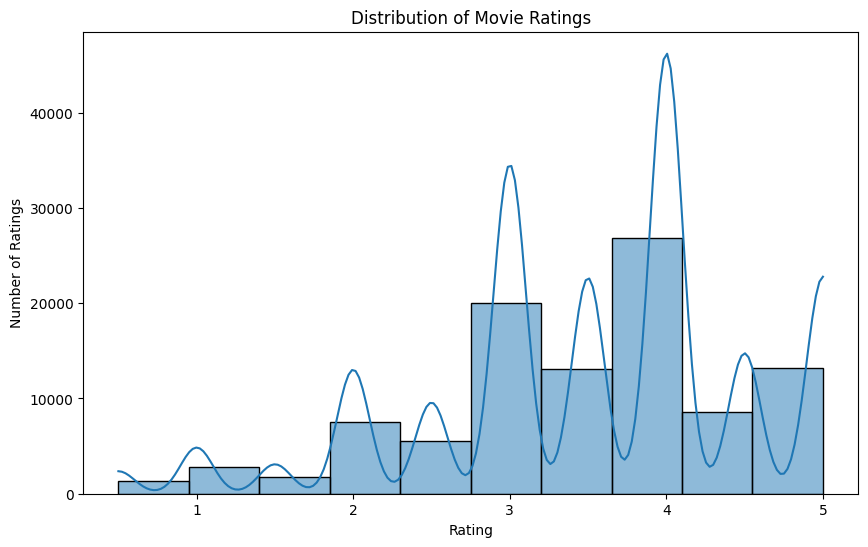

In [91]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

In [92]:
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')
genre_ratings = merged_df.explode('genres')

print('Merged DataFrame with exploded genres head:')
print(genre_ratings.head())
print(f'Shape of genre_ratings: {genre_ratings.shape}')

Merged DataFrame with exploded genres head:
   userId  movieId  rating           timestamp  \
0       1      804     4.0 2000-07-30 18:08:19   
0       1      804     4.0 2000-07-30 18:08:19   
1       1     1210     5.0 2000-07-30 18:08:19   
1       1     1210     5.0 2000-07-30 18:08:19   
1       1     1210     5.0 2000-07-30 18:08:19   

                                               title     genres  
0                               She's the One (1996)     Comedy  
0                               She's the One (1996)    Romance  
1  Star Wars: Episode VI - Return of the Jedi (1983)     Action  
1  Star Wars: Episode VI - Return of the Jedi (1983)  Adventure  
1  Star Wars: Episode VI - Return of the Jedi (1983)     Sci-Fi  
Shape of genre_ratings: (274480, 6)


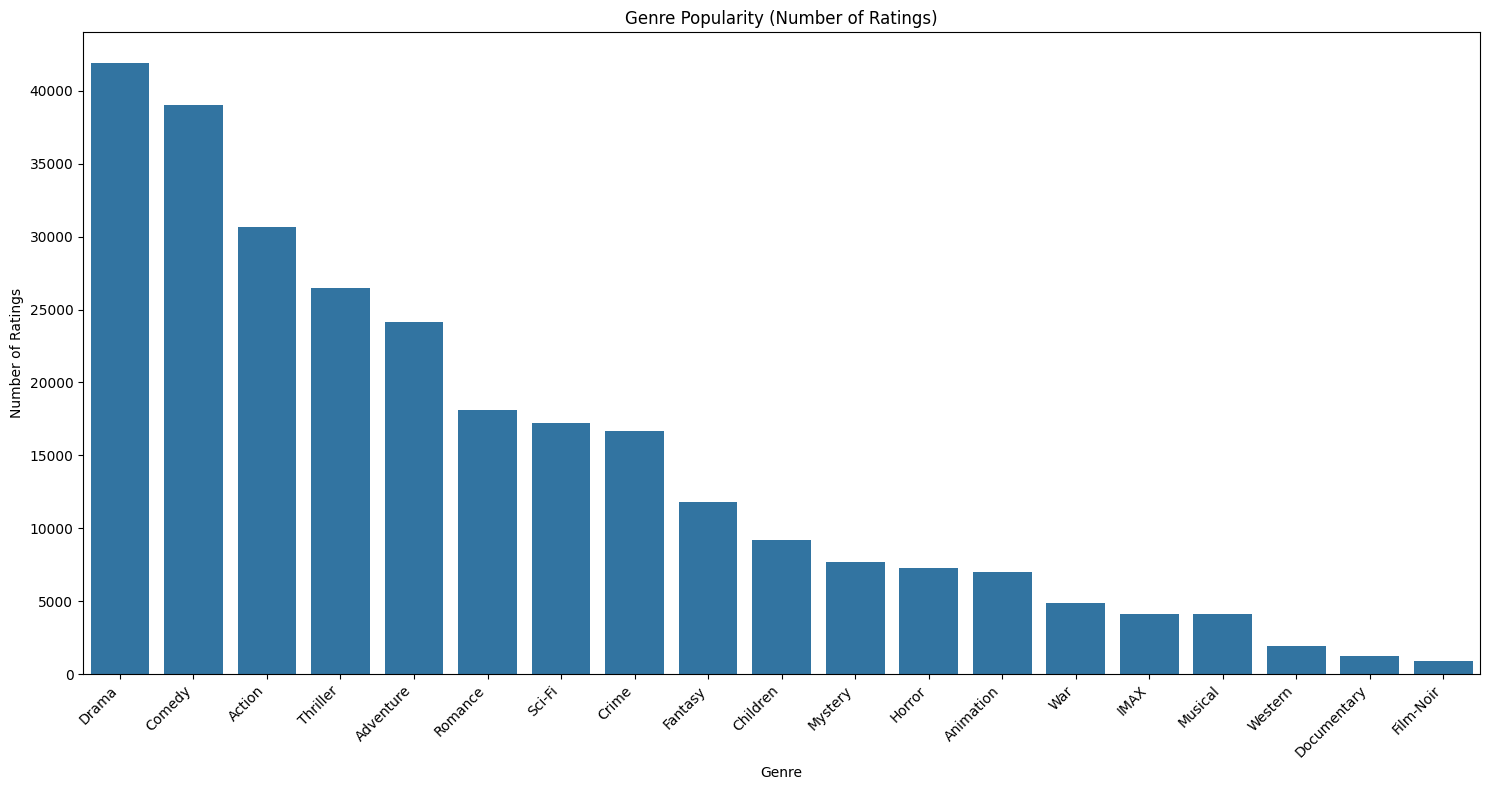

/tmp/ipython-input-2611166816.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='average_rating', data=genre_avg_ratings, palette='viridis')


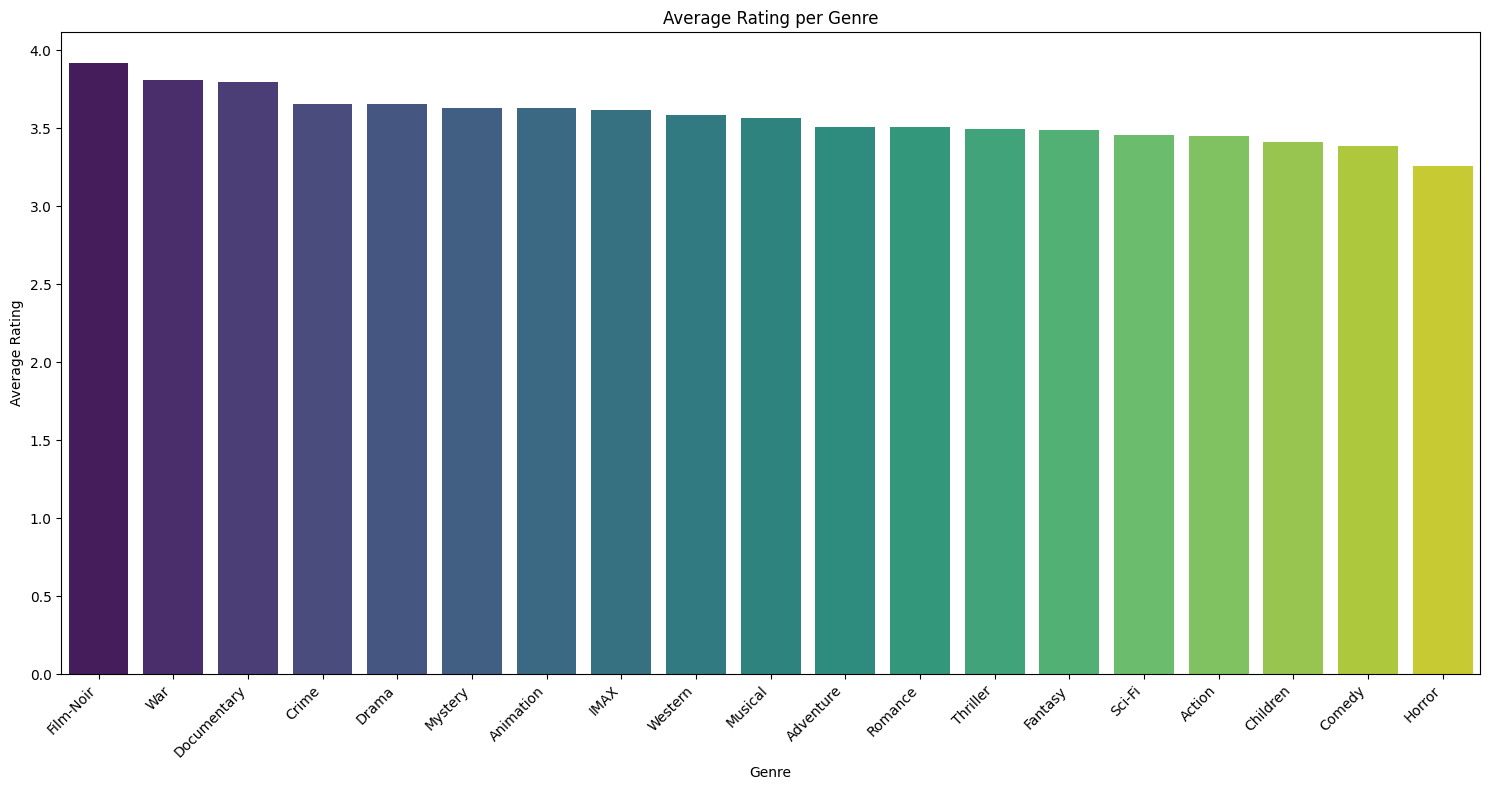

Genre popularity and average rating analysis completed with plots.


In [93]:
import numpy as np

genre_stats = genre_ratings.groupby('genres').agg(rating_count=('rating', 'count'), average_rating=('rating', 'mean')).reset_index()

genre_stats = genre_stats[genre_stats['genres'] != ''].dropna(subset=['genres'])

genre_popularity = genre_stats.sort_values(by='rating_count', ascending=False)

genre_avg_ratings = genre_stats.sort_values(by='average_rating', ascending=False)


plt.figure(figsize=(15, 8))
sns.barplot(x='genres', y='rating_count', data=genre_popularity)
plt.title('Genre Popularity (Number of Ratings)')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x='genres', y='average_rating', data=genre_avg_ratings, palette='viridis')
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('Genre popularity and average rating analysis completed with plots.')

**Reasoning**:
The previous code produced a `FutureWarning` due to `palette` being passed without `hue` in `sns.barplot`. I will fix this by setting `hue='genres'` and `legend=False` to align with the suggestion.



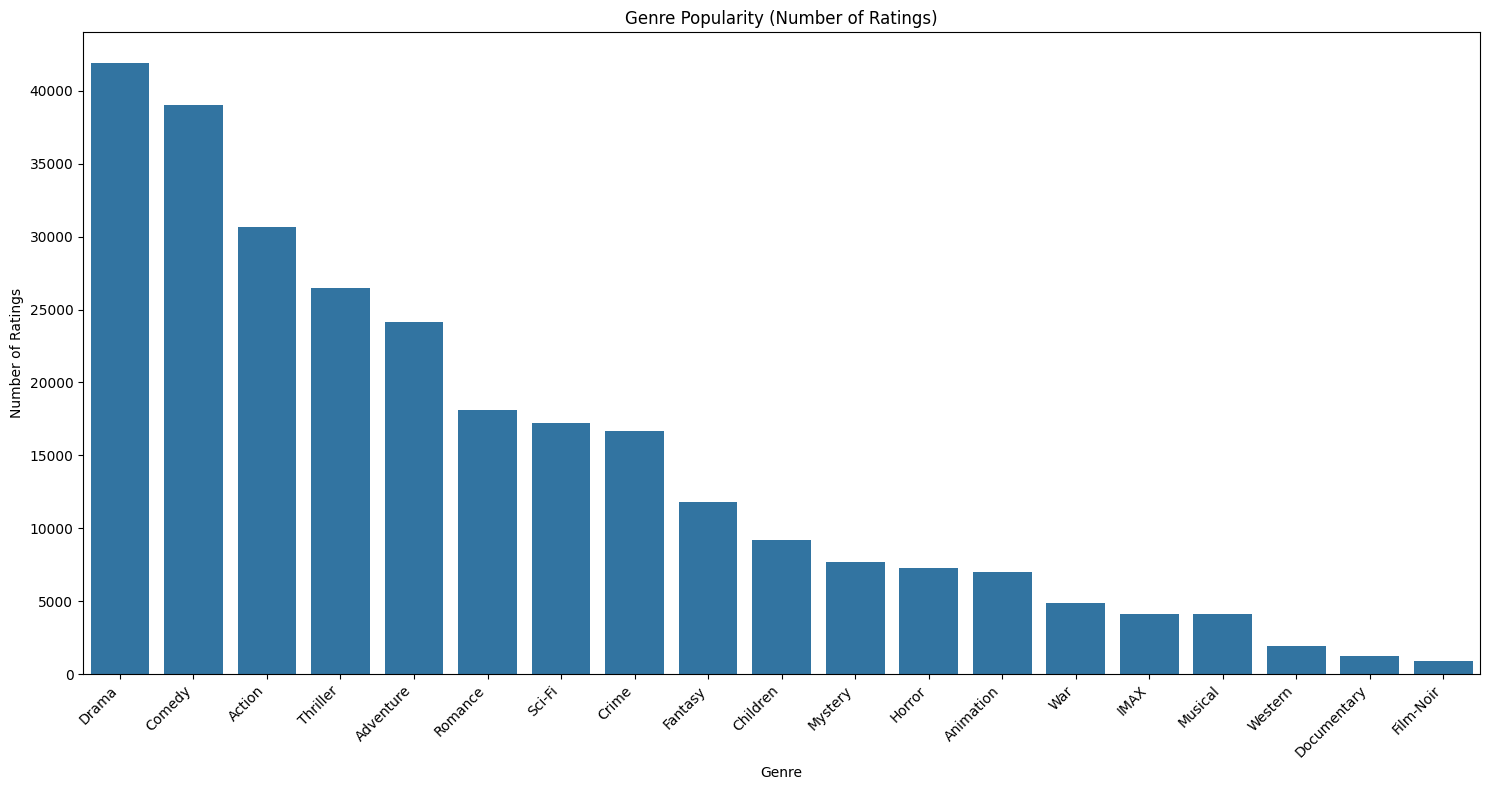

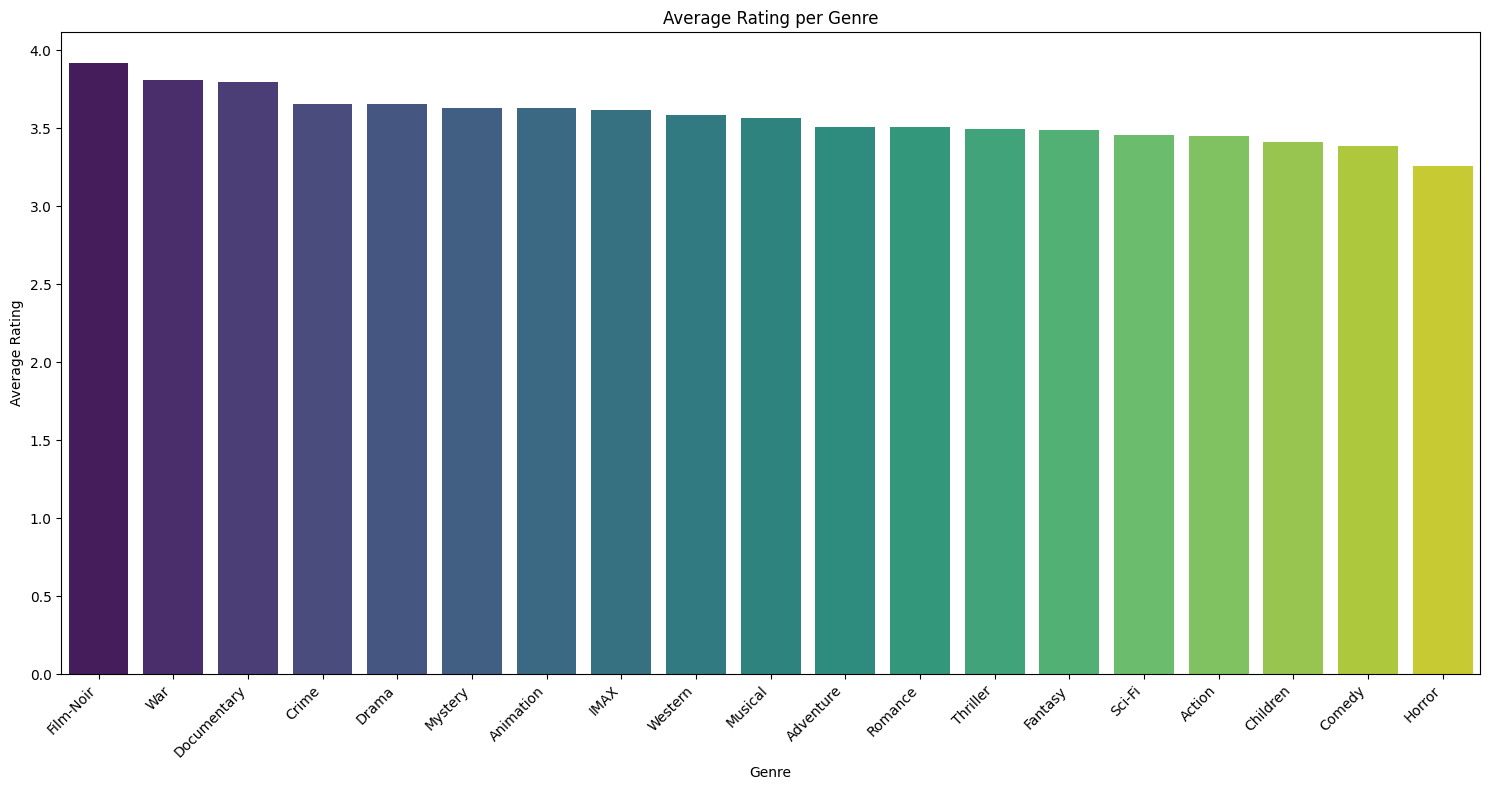

Genre popularity and average rating analysis completed with plots.


In [94]:
import numpy as np

genre_stats = genre_ratings.groupby('genres').agg(rating_count=('rating', 'count'), average_rating=('rating', 'mean')).reset_index()

genre_stats = genre_stats[genre_stats['genres'] != ''].dropna(subset=['genres'])

genre_popularity = genre_stats.sort_values(by='rating_count', ascending=False)

genre_avg_ratings = genre_stats.sort_values(by='average_rating', ascending=False)


plt.figure(figsize=(15, 8))
sns.barplot(x='genres', y='rating_count', data=genre_popularity)
plt.title('Genre Popularity (Number of Ratings)')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x='genres', y='average_rating', data=genre_avg_ratings, hue='genres', palette='viridis', legend=False)
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('Genre popularity and average rating analysis completed with plots.')

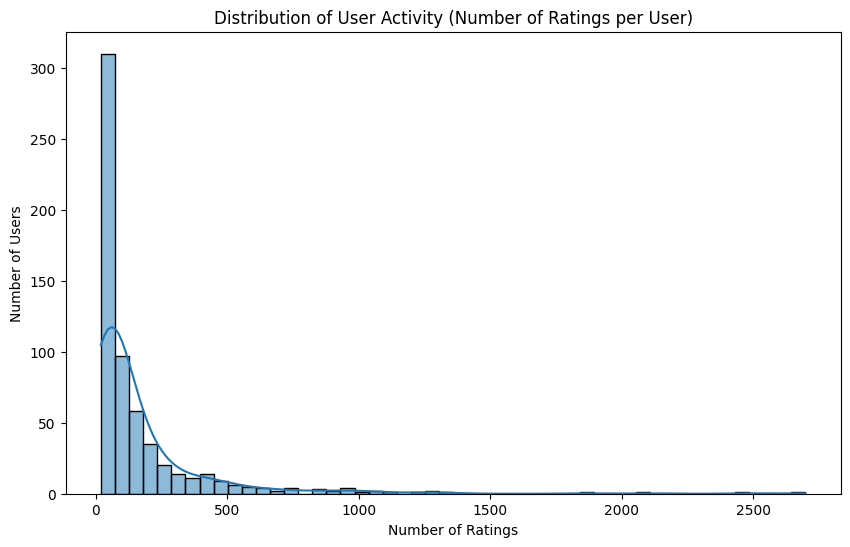

User activity histogram generated.


In [95]:
user_activity = ratings_df.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=50, kde=True)
plt.title('Distribution of User Activity (Number of Ratings per User)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

print('User activity histogram generated.')

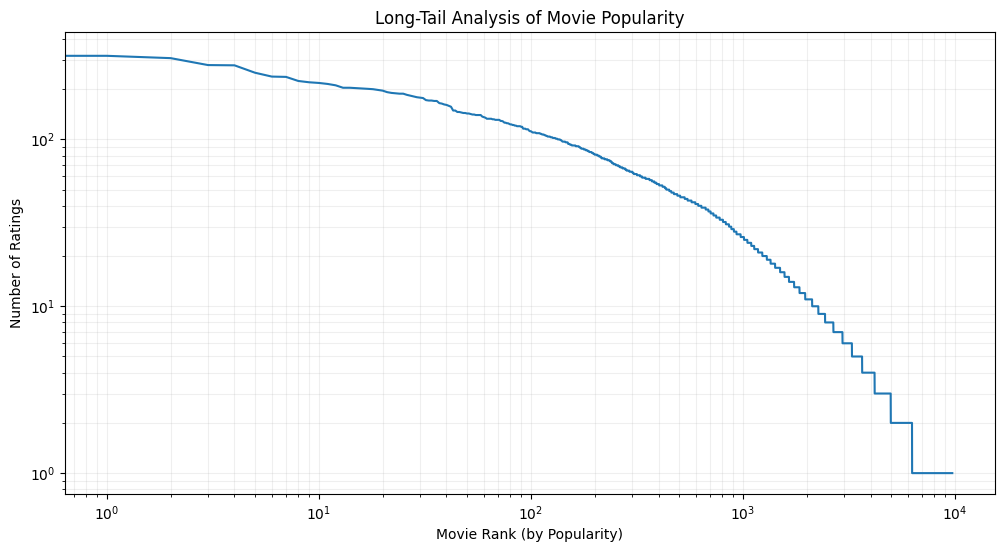

Long-tail analysis of movie popularity completed with plot.


In [96]:
movie_rating_counts = ratings_df.groupby('movieId')['rating'].count().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(movie_rating_counts)), y=movie_rating_counts.values)
plt.title('Long-Tail Analysis of Movie Popularity')
plt.xlabel('Movie Rank (by Popularity)')
plt.ylabel('Number of Ratings')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print('Long-tail analysis of movie popularity completed with plot.')

In [97]:
ratings_df['year'] = ratings_df['timestamp'].dt.year
year_stats = ratings_df.groupby('year').agg(
    rating_count=('rating', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

print('Yearly Rating Statistics head:')
print(year_stats.head())
print(f'Shape of Yearly Rating Statistics: {year_stats.shape}')

Yearly Rating Statistics head:
   year  rating_count  average_rating
0  1996          6040        3.535927
1  1997          1916        3.727557
2  1998           507        3.435897
3  1999          2439        3.772448
4  2000         10061        3.392506
Shape of Yearly Rating Statistics: (23, 3)


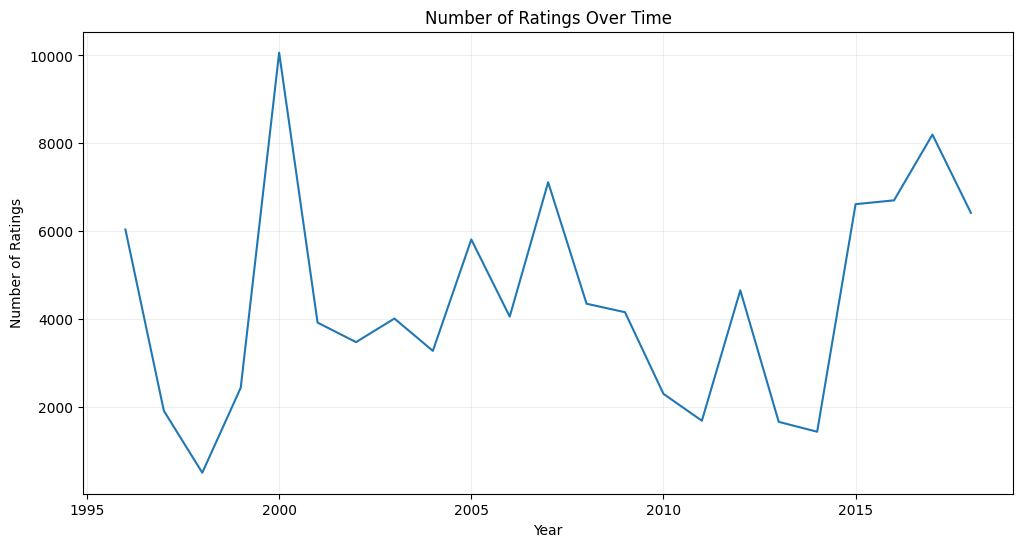

Line plot of number of ratings over time generated.


In [98]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='rating_count', data=year_stats)
plt.title('Number of Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print('Line plot of number of ratings over time generated.')

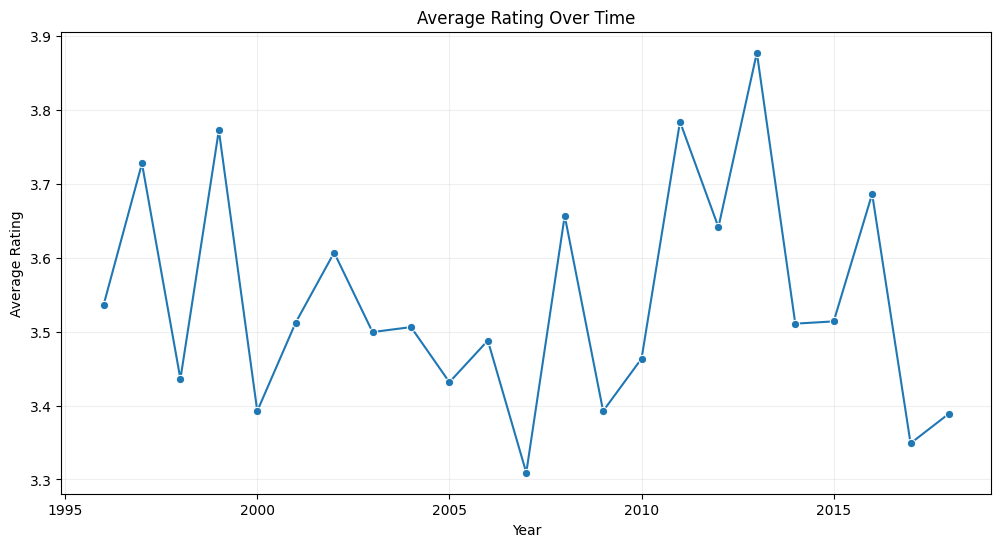

Line plot of average rating over time generated.


In [99]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='average_rating', data=year_stats, marker='o')
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print('Line plot of average rating over time generated.')

In [100]:
average_ratings = train_ratings.groupby('movieId')['rating'].mean().reset_index()
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

print('Average Ratings head:')
print(average_ratings.head())
print(f'Shape of average_ratings: {average_ratings.shape}')

Average Ratings head:
   movieId  average_rating
0        1        3.920930
1        2        3.426606
2        3        3.245098
3        4        2.357143
4        5        3.072917
Shape of average_ratings: (9701, 2)


In [101]:
rating_counts = train_ratings.groupby('movieId')['rating'].count().reset_index()
rating_counts.rename(columns={'rating': 'rating_count'}, inplace=True)

print('Rating Counts head:')
print(rating_counts.head())
print(f'Shape of rating_counts: {rating_counts.shape}')

Rating Counts head:
   movieId  rating_count
0        1           215
1        2           109
2        3            51
3        4             7
4        5            48
Shape of rating_counts: (9701, 2)


In [102]:
movie_popularity = pd.merge(average_ratings, rating_counts, on='movieId', how='inner')

print('Movie Popularity DataFrame head:')
print(movie_popularity.head())
print(f'Shape of movie_popularity: {movie_popularity.shape}')

Movie Popularity DataFrame head:
   movieId  average_rating  rating_count
0        1        3.920930           215
1        2        3.426606           109
2        3        3.245098            51
3        4        2.357143             7
4        5        3.072917            48
Shape of movie_popularity: (9701, 3)


In [103]:
min_ratings_threshold = 50

print(f'Minimum ratings threshold defined: {min_ratings_threshold}')

Minimum ratings threshold defined: 50


In [104]:
filtered_movie_popularity = movie_popularity[movie_popularity['rating_count'] >= min_ratings_threshold]

print('Filtered Movie Popularity DataFrame head:')
print(filtered_movie_popularity.head())
print(f'Shape of Filtered Movie Popularity DataFrame: {filtered_movie_popularity.shape}')

Filtered Movie Popularity DataFrame head:
   movieId  average_rating  rating_count
0        1        3.920930           215
1        2        3.426606           109
2        3        3.245098            51
5        6        3.950495           101
6        7        3.185185            54
Shape of Filtered Movie Popularity DataFrame: (446, 3)


In [105]:
popular_movies = filtered_movie_popularity.sort_values(by=['average_rating', 'rating_count'], ascending=[False, False])

print('Popular Movies DataFrame head:')
print(popular_movies.head())
print(f'Shape of Popular Movies DataFrame: {popular_movies.shape}')

Popular Movies DataFrame head:
      movieId  average_rating  rating_count
277       318        4.428571           315
657       858        4.283069           189
2221     2959        4.272936           218
972      1276        4.271930            57
600       750        4.260417            96
Shape of Popular Movies DataFrame: (446, 3)


In [106]:
def get_popular_recommendations(num_recommendations):
    return popular_movies.head(num_recommendations)

print('Function `get_popular_recommendations` defined.')

Function `get_popular_recommendations` defined.


In [107]:
top_10_recommendations = get_popular_recommendations(10)

recommended_movies_with_titles = pd.merge(top_10_recommendations, movies_df[['movieId', 'title']], on='movieId', how='left')

print('Top 10 Popular Movie Recommendations:')
print(recommended_movies_with_titles)

Top 10 Popular Movie Recommendations:
   movieId  average_rating  rating_count  \
0      318        4.428571           315   
1      858        4.283069           189   
2     2959        4.272936           218   
3     1276        4.271930            57   
4      750        4.260417            96   
5     1221        4.253906           128   
6      904        4.253012            83   
7     1213        4.252000           125   
8    48516        4.245283           106   
9     1197        4.244681           141   

                                               title  
0                   Shawshank Redemption, The (1994)  
1                              Godfather, The (1972)  
2                                  Fight Club (1999)  
3                              Cool Hand Luke (1967)  
4  Dr. Strangelove or: How I Learned to Stop Worr...  
5                     Godfather: Part II, The (1974)  
6                                 Rear Window (1954)  
7                                  Go

In [108]:
def evaluate_popularity_recommender(num_recommendations):
    top_popular_movie_ids = popular_movies.head(num_recommendations)['movieId'].tolist()

    hit_rates = []
    average_precisions = []

    test_users_grouped = test_ratings.groupby('userId')

    for userId, user_test_ratings in test_users_grouped:
        test_movie_id = user_test_ratings['movieId'].iloc[0]

        is_hit = 1 if test_movie_id in top_popular_movie_ids else 0
        hit_rates.append(is_hit)

        if is_hit:
            average_precisions.append(1.0)
        else:
            average_precisions.append(0.0)

    hr = sum(hit_rates) / len(hit_rates) if hit_rates else 0
    map_score = sum(average_precisions) / len(average_precisions) if average_precisions else 0

    return hr, map_score

num_recommendations_to_evaluate = 10
hr_score, map_score = evaluate_popularity_recommender(num_recommendations_to_evaluate)

print(f'Evaluation Results for Top {num_recommendations_to_evaluate} Popular Recommendations:')
print(f'Hit Ratio (HR): {hr_score:.4f}')
print(f'Mean Average Precision (MAP): {map_score:.4f}')

Evaluation Results for Top 10 Popular Recommendations:
Hit Ratio (HR): 0.0180
Mean Average Precision (MAP): 0.0180


In [109]:
def generate_explanation(movieId):
    movie_info = movies_df[movies_df['movieId'] == movieId].iloc[0]
    title = movie_info['title']
    genres = movie_info['genres']

    movie_tags_entry = movie_tags_df[movie_tags_df['movieId'] == movieId]
    tags = movie_tags_entry['tags'].iloc[0] if not movie_tags_entry.empty else []

    limited_tags = tags[:5]

    genres_str = ', '.join(genres) if genres else 'various genres'

    if limited_tags:
        tags_str = f" tagged with {', '.join(limited_tags)}"
    else:
        tags_str = ""

    explanation = f"{title} is a {genres_str} film{tags_str}."
    return explanation

print('Function `generate_explanation` defined.')

Function `generate_explanation` defined.


In [110]:
recommended_movies_with_titles['explanation'] = recommended_movies_with_titles['movieId'].apply(generate_explanation)

print('Top 10 Popular Movie Recommendations with Explanations:')
print(recommended_movies_with_titles[['title', 'average_rating', 'explanation']])

Top 10 Popular Movie Recommendations with Explanations:
                                               title  average_rating  \
0                   Shawshank Redemption, The (1994)        4.428571   
1                              Godfather, The (1972)        4.283069   
2                                  Fight Club (1999)        4.272936   
3                              Cool Hand Luke (1967)        4.271930   
4  Dr. Strangelove or: How I Learned to Stop Worr...        4.260417   
5                     Godfather: Part II, The (1974)        4.253906   
6                                 Rear Window (1954)        4.253012   
7                                  Goodfellas (1990)        4.252000   
8                               Departed, The (2006)        4.245283   
9                         Princess Bride, The (1987)        4.244681   

                                         explanation  
0  Shawshank Redemption, The (1994) is a Crime, D...  
1  Godfather, The (1972) is a Crime, Dram

In [111]:
print('Top 10 Popular Movie Recommendations with Explanations:')
print(recommended_movies_with_titles[['title', 'average_rating', 'explanation']])

Top 10 Popular Movie Recommendations with Explanations:
                                               title  average_rating  \
0                   Shawshank Redemption, The (1994)        4.428571   
1                              Godfather, The (1972)        4.283069   
2                                  Fight Club (1999)        4.272936   
3                              Cool Hand Luke (1967)        4.271930   
4  Dr. Strangelove or: How I Learned to Stop Worr...        4.260417   
5                     Godfather: Part II, The (1974)        4.253906   
6                                 Rear Window (1954)        4.253012   
7                                  Goodfellas (1990)        4.252000   
8                               Departed, The (2006)        4.245283   
9                         Princess Bride, The (1987)        4.244681   

                                         explanation  
0  Shawshank Redemption, The (1994) is a Crime, D...  
1  Godfather, The (1972) is a Crime, Dram

In [112]:
movie_features_prepared = movie_features_df.set_index('movieId')

if 'NaN' in movie_features_prepared.columns:
    movie_features_prepared = movie_features_prepared.drop(columns=['NaN'])

print('Prepared Movie Features DataFrame head:')
print(movie_features_prepared.head())
print(f'Shape of Prepared Movie Features DataFrame: {movie_features_prepared.shape}')

Prepared Movie Features DataFrame head:
         Adventure  Animation  Children  Comedy  Fantasy  Romance  Drama  \
movieId                                                                    
1                1          1         1       1        1        0      0   
2                1          0         1       0        1        0      0   
3                0          0         0       1        0        1      0   
4                0          0         0       1        0        1      1   
5                0          0         0       1        0        0      0   

         Action  Crime  Thriller  ...  world war i  world war ii  writing  \
movieId                           ...                                       
1             0      0         0  ...          0.0           0.0      0.0   
2             0      0         0  ...          0.0           0.0      0.0   
3             0      0         0  ...          0.0           0.0      0.0   
4             0      0         0  ...     

In [113]:
from sklearn.metrics.pairwise import cosine_similarity

movie_similarity_matrix = cosine_similarity(movie_features_prepared)

movie_similarity_df = pd.DataFrame(
    movie_similarity_matrix,
    index=movie_features_prepared.index,
    columns=movie_features_prepared.index
)

print('Movie Similarity Matrix head (first 5x5):')
print(movie_similarity_df.iloc[:5, :5])
print(f'Shape of Movie Similarity Matrix: {movie_similarity_df.shape}')

Movie Similarity Matrix head (first 5x5):
movieId         1         2         3         4         5
movieId                                                  
1        1.000000  0.428571  0.188982  0.218218  0.218218
2        0.428571  1.000000  0.000000  0.000000  0.000000
3        0.188982  0.000000  1.000000  0.577350  0.288675
4        0.218218  0.000000  0.577350  1.000000  0.333333
5        0.218218  0.000000  0.288675  0.333333  1.000000
Shape of Movie Similarity Matrix: (9742, 9742)


In [114]:
def generate_enhanced_explanation(userId, recommended_movieId, num_similar_movies=2, rating_threshold=4.0):
    user_liked_movies = train_ratings[(train_ratings['userId'] == userId) & (train_ratings['rating'] >= rating_threshold)]

    if user_liked_movies.empty:
        return f"We recommend '{movies_df[movies_df['movieId'] == recommended_movieId]['title'].iloc[0]}' based on its overall popularity."

    similarities = []
    for _, row in user_liked_movies.iterrows():
        liked_movieId = row['movieId']
        if liked_movieId in movie_similarity_df.columns and recommended_movieId in movie_similarity_df.index:
            similarity = movie_similarity_df.loc[recommended_movieId, liked_movieId]
            similarities.append((liked_movieId, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)

    top_similar_liked_movies = [s[0] for s in similarities if s[1] > 0][:num_similar_movies]

    if not top_similar_liked_movies:
        return f"We recommend '{movies_df[movies_df['movieId'] == recommended_movieId]['title'].iloc[0]}' because it aligns with our broader recommendations."

    recommended_movie_title = movies_df[movies_df['movieId'] == recommended_movieId]['title'].iloc[0]
    recommended_movie_genres = movies_df[movies_df['movieId'] == recommended_movieId]['genres'].iloc[0]
    recommended_movie_tags_entry = movie_tags_df[movie_tags_df['movieId'] == recommended_movieId]
    recommended_movie_tags = recommended_movie_tags_entry['tags'].iloc[0] if not recommended_movie_tags_entry.empty else []

    liked_movie_titles = []
    all_common_genres = set()
    all_common_tags = set()

    for liked_mid in top_similar_liked_movies:
        liked_movie_title = movies_df[movies_df['movieId'] == liked_mid]['title'].iloc[0]
        liked_movie_titles.append(liked_movie_title)

        liked_movie_genres = movies_df[movies_df['movieId'] == liked_mid]['genres'].iloc[0]
        if recommended_movie_genres and liked_movie_genres:
            all_common_genres.update(set(recommended_movie_genres).intersection(set(liked_movie_genres)))

        liked_movie_tags_entry = movie_tags_df[movie_tags_df['movieId'] == liked_mid]
        liked_movie_tags = liked_movie_tags_entry['tags'].iloc[0] if not liked_movie_tags_entry.empty else []
        if recommended_movie_tags and liked_movie_tags:
            all_common_tags.update(set(recommended_movie_tags).intersection(set(liked_movie_tags)))

    explanation_parts = [
        f"Because you liked {', '.join(liked_movie_titles)}"
    ]

    if all_common_tags:
        explanation_parts.append(f"which share the tags '{', '.join(list(all_common_tags)[:3])}'")

    if all_common_genres:
        explanation_parts.append(f"and are both '{', '.join(list(all_common_genres)[:2])}' films")

    explanation = f"We recommend '{recommended_movie_title}' " + " ".join(explanation_parts) + "."

    return explanation

print('Function `generate_enhanced_explanation` defined.')

Function `generate_enhanced_explanation` defined.


In [115]:
print('Testing generate_enhanced_explanation function:')

user_id_1 = 1
recommended_movie_id_1 = 2492
explanation_1 = generate_enhanced_explanation(user_id_1, recommended_movie_id_1)
print(f"Explanation for User {user_id_1}, recommending Movie {recommended_movie_id_1}:\n{explanation_1}\n")

user_id_2 = 2
recommended_movie_id_2 = 80489
explanation_2 = generate_enhanced_explanation(user_id_2, recommended_movie_id_2)
print(f"Explanation for User {user_id_2}, recommending Movie {recommended_movie_id_2}:\n{explanation_2}\n")

user_id_3 = 3
recommended_movie_id_3 = 2424
explanation_3 = generate_enhanced_explanation(user_id_3, recommended_movie_id_3)
print(f"Explanation for User {user_id_3}, recommending Movie {recommended_movie_id_3}:\n{explanation_3}\n")

Testing generate_enhanced_explanation function:
Explanation for User 1, recommending Movie 2492:
We recommend '20 Dates (1998)' Because you liked She's the One (1996), Wedding Singer, The (1998) and are both 'Comedy, Romance' films.

Explanation for User 2, recommending Movie 80489:
We recommend 'Town, The (2010)' Because you liked Departed, The (2006), Kill Bill: Vol. 1 (2003) and are both 'Thriller, Drama' films.

Explanation for User 3, recommending Movie 2424:
We recommend 'You've Got Mail (1998)' Because you liked The Lair of the White Worm (1988) and are both 'Comedy' films.



In [120]:
import numpy as np

def evaluate_ranking_metrics(k):
    precision_at_k = []
    recall_at_k = []
    ndcg_at_k = []

    for userId, user_test_ratings in test_ratings.groupby('userId'):
        actual_movie_id = user_test_ratings['movieId'].iloc[0]

        recommended_movies = get_popular_recommendations(k)
        recommended_movie_ids = recommended_movies['movieId'].tolist()

        is_hit = 1 if actual_movie_id in recommended_movie_ids else 0

        if k > 0:
            pk = is_hit / k
        else:
            pk = 0.0
        precision_at_k.append(pk)

        rk = is_hit
        recall_at_k.append(rk)

        dcg = 0.0
        if is_hit:
            try:
                rank = recommended_movie_ids.index(actual_movie_id) + 1
                dcg = 1 / np.log2(rank + 1)
            except ValueError:
                pass

        ideal_dcg = 1.0

        ndcg = dcg / ideal_dcg
        ndcg_at_k.append(ndcg)

    avg_precision_at_k = np.mean(precision_at_k) if precision_at_k else 0.0
    avg_recall_at_k = np.mean(recall_at_k) if recall_at_k else 0.0
    avg_ndcg_at_k = np.mean(ndcg_at_k) if ndcg_at_k else 0.0

    return avg_precision_at_k, avg_recall_at_k, avg_ndcg_at_k

k_value = 10
hr_score, avg_recall_at_k, avg_ndcg_at_k = evaluate_ranking_metrics(k_value)

print(f'Evaluation Results for K={k_value} Popular Recommendations:')
print(f'Precision@{k_value}: {hr_score:.4f}')
print(f'Recall@{k_value}: {avg_recall_at_k:.4f}')
print(f'NDCG@{k_value}: {avg_ndcg_at_k:.4f}')

Evaluation Results for K=10 Popular Recommendations:
Precision@10: 0.0018
Recall@10: 0.0180
NDCG@10: 0.0096


In [121]:
def calculate_catalog_coverage(k):
    all_recommended_movie_ids = set()

    for userId, _ in test_ratings.groupby('userId'):
        recommended_movies = get_popular_recommendations(k)
        all_recommended_movie_ids.update(recommended_movies['movieId'].tolist())

    total_unique_movies_in_catalog = movies_df['movieId'].nunique()
    catalog_coverage = len(all_recommended_movie_ids) / total_unique_movies_in_catalog

    return catalog_coverage

k_value = 10
catalog_coverage_score = calculate_catalog_coverage(k_value)

print(f'Catalog Coverage @{k_value}: {catalog_coverage_score:.4f}')

Catalog Coverage @10: 0.0010


In [122]:
def calculate_intra_list_diversity(k):
    diversity_scores = []

    for userId, _ in test_ratings.groupby('userId'):
        recommended_movies = get_popular_recommendations(k)
        recommended_movie_ids = recommended_movies['movieId'].tolist()

        if len(recommended_movie_ids) < 2:
            diversity_scores.append(0.0)
            continue

        pairwise_similarities = []
        for i in range(len(recommended_movie_ids)):
            for j in range(i + 1, len(recommended_movie_ids)):
                movie1 = recommended_movie_ids[i]
                movie2 = recommended_movie_ids[j]

                if movie1 in movie_similarity_df.index and movie2 in movie_similarity_df.columns:
                    similarity = movie_similarity_df.loc[movie1, movie2]
                    pairwise_similarities.append(similarity)

        if pairwise_similarities:
            avg_similarity = np.mean(pairwise_similarities)
            diversity_scores.append(1 - avg_similarity)
        else:
            diversity_scores.append(0.0)

    avg_intra_list_diversity = np.mean(diversity_scores) if diversity_scores else 0.0
    return avg_intra_list_diversity

k_value = 10
intra_list_diversity_score = calculate_intra_list_diversity(k_value)

print(f'Intra-List Diversity @{k_value}: {intra_list_diversity_score:.4f}')

Intra-List Diversity @10: 0.8079


In [123]:
def calculate_popularity_novelty(k):
    novelty_scores = []

    movie_popularity_counts = train_ratings.groupby('movieId')['rating'].count()
    log_popularity = np.log(movie_popularity_counts + 1)

    for userId, _ in test_ratings.groupby('userId'):
        recommended_movies = get_popular_recommendations(k)
        recommended_movie_ids = recommended_movies['movieId'].tolist()

        user_novelty_score = 0.0
        num_valid_movies = 0
        for movie_id in recommended_movie_ids:
            if movie_id in log_popularity.index:
                user_novelty_score += 1 / log_popularity[movie_id]
                num_valid_movies += 1

        if num_valid_movies > 0:
            novelty_scores.append(user_novelty_score / num_valid_movies)
        else:
            novelty_scores.append(0.0)

    avg_popularity_novelty = np.mean(novelty_scores) if novelty_scores else 0.0
    return avg_popularity_novelty

k_value = 10
popularity_novelty_score = calculate_popularity_novelty(k_value)

print(f'Popularity-Normalized Hits @{k_value}: {popularity_novelty_score:.4f}')

Popularity-Normalized Hits @10: 0.2069
